# First column
This notebook attempts to replicate the first column of the He table.  
Due to the limitation of the NY Fed table, we first test on the data up to 2014.

In [ ]:
import pandas as pd 
import numpy as np

In [132]:
import wrds

# Connect to WRDS
from settings import config
# Make sure that you have included the line
# WRDS_USERNAME = your_wrds_username
# in the .env file
WRDS_USERNAME = config("WRDS_USERNAME") 
db = wrds.Connection(wrds_username=WRDS_USERNAME)

Loading library list...
Done


In [16]:
ny_fed_df = pd.read_excel("../data_manual/Dealer_Lists_1960_to_2014.xls", sheet_name="Dealer Alpha",skiprows=2)

ny_fed_df = ny_fed_df.drop(ny_fed_df.columns[-1],axis=1)
# ny_fed_df["Primary Dealer"] = ny_fed_df["Primary Dealer"].str.strip()
ny_fed_df.head(3)

,Primary Dealer,Start Date,End Date
0,"ABN AMRO BANK, N.V., NY BR",2002-12-09,2006-09-15 00:00:00
1,ABN AMRO INCORPORATED,1998-09-29,2002-12-08 00:00:00
2,"AUBREY G. LANSTON & CO., INC.",1960-05-19,2000-04-17 00:00:00


In [ ]:
# the last column is object bc there is "current" strings within the column
ny_fed_df.dtypes

Primary Dealer            object
Start Date        datetime64[ns]
End Date                  object
dtype: object

In [20]:
map_helper_df = pd.read_csv("../data_manual/compustat_nyfed_map_helper.csv",index_col=0)
map_helper_df.head(3)

,Primary Dealer,compustat_name
0,"ABN AMRO BANK, N.V., NY BR",ABN-AMRO HOLDINGS NV
1,ABN AMRO INCORPORATED,ABN-AMRO HOLDINGS NV
2,"AUBREY G. LANSTON & CO., INC.",NaN


In [45]:
dealer_df = pd.merge(map_helper_df, ny_fed_df, on="Primary Dealer", how ="left")

In [44]:
map_helper_df.head(10)

,Primary Dealer,compustat_name
0,"ABN AMRO BANK, N.V., NY BR",ABN-AMRO HOLDINGS NV
1,ABN AMRO INCORPORATED,ABN-AMRO HOLDINGS NV
2,"AUBREY G. LANSTON & CO., INC.",NaN
3,"BA SECURITIES, INC.",NaN
4,BANC OF AMERICA SECURITIES LLC,BANK OF AMERICA CORP
5,"BANC ONE CAPITAL MARKETS, INC",BANK ONE CORP
6,BANCAMERICA ROBERTSON STEPHEN,BANKAMERICA CORP-OLD
7,"BANCAMERICA SECURITIES, INC.",BANKAMERICA CORP-OLD
8,BANK OF AMERICA NT & SA,BANK OF AMERICA CORP
9,"BANK OF NOVA SCOTIA, NEW YORK AGENCY",BANK OF NOVA SCOTIA


In [46]:
dealer_df.head(10)

,Primary Dealer,compustat_name,Start Date,End Date
0,"ABN AMRO BANK, N.V., NY BR",ABN-AMRO HOLDINGS NV,2002-12-09,2006-09-15 00:00:00
1,ABN AMRO INCORPORATED,ABN-AMRO HOLDINGS NV,1998-09-29,2002-12-08 00:00:00
2,"AUBREY G. LANSTON & CO., INC.",NaN,1960-05-19,2000-04-17 00:00:00
3,"BA SECURITIES, INC.",NaN,1994-04-18,1997-09-30 00:00:00
4,BANC OF AMERICA SECURITIES LLC,BANK OF AMERICA CORP,1999-05-17,2010-11-01 00:00:00
5,"BANC ONE CAPITAL MARKETS, INC",BANK ONE CORP,1999-04-01,2004-08-01 00:00:00
6,BANCAMERICA ROBERTSON STEPHEN,BANKAMERICA CORP-OLD,1997-10-01,1998-08-31 00:00:00
7,"BANCAMERICA SECURITIES, INC.",BANKAMERICA CORP-OLD,1998-09-01,1998-09-30 00:00:00
8,BANK OF AMERICA NT & SA,BANK OF AMERICA CORP,1971-11-17,1994-04-15 00:00:00
9,"BANK OF NOVA SCOTIA, NEW YORK AGENCY",BANK OF NOVA SCOTIA,2011-10-04,Current Dealer


In [51]:
# now try till 2014
dealer_df.loc[dealer_df["End Date"] == "Current Dealer", "End Date"] = "2014-12-31"
dealer_df["End Date"] = pd.to_datetime(dealer_df["End Date"])

## Map compustat and CRSP
We want to use Compustat compn as a key to connect the ny fed table and the crsp monthly data

https://wrds-www.wharton.upenn.edu/pages/support/manuals-and-overviews/crsp/crspcompustat-merged-ccm/wrds-overview-crspcompustat-merged-ccm/ 

Here, we try the cusip method. 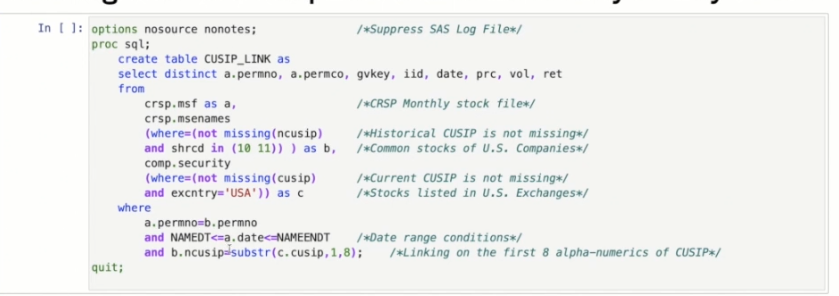

In [76]:
compustat_list = dealer_df['compustat_name'].dropna().unique().tolist()

# Formatting for SQL IN clause
sql_in_clause = ", ".join(f"'{name}'" for name in compustat_list)

# Print SQL query
sql_query = f"SELECT DISTINCT conm, gvkey,cusip FROM comp.fundq WHERE conm IN ({sql_in_clause});"
print(sql_query)

SELECT DISTINCT conm, gvkey,cusip FROM comp.fundq WHERE conm IN ('ABN-AMRO HOLDINGS NV', 'BANK OF AMERICA CORP', 'BANK ONE CORP', 'BANKAMERICA CORP-OLD', 'BANK OF NOVA SCOTIA', 'BANKERS TRUST CORP', 'BARCLAYS PLC', 'BANK OF MONTREAL', 'BNP PARIBAS', 'CHASE MANHATTAN CORP -OLD', 'CHEMICAL FINANCIAL CORP', 'CITYBANK', 'CITY HOLDING CO', 'CONTINENTAL BANK CORP', 'CREDIT SUISSE GROUP', 'DEUTSCHE BANK AG', 'ISRAEL DISCOUNT BANK LTD', 'DRESDNER BANK AG', 'FIRST CHICAGO CORP', 'FIRST INTERSTATE BANCSYSTEM', 'GOLDMAN SACHS GROUP INC', 'GREENWICH FINANCIAL CORP', 'HSBC HLDGS PLC', 'IRVING BANK CORP', 'JPMORGAN CHASE & CO', 'JEFFERIES GROUP LLC', 'LEHMAN BROTHERS HOLDINGS INC', 'LLOYDS BANKING GROUP PLC', 'MANUFACTURERS HANOVER CORP', 'MERRILL LYNCH & CO INC', 'MIZUHO FINANCIAL GROUP INC', 'MORGAN STANLEY', 'NOMURA HOLDINGS INC', 'NORTHERN TRUST CORP', 'PRUDENTIAL BANCORP INC', 'ROYAL BANK OF CANADA', 'SOCIETE GENERALE GROUP', 'SECURITY PACIFIC CORP', 'TORONTO DOMINION BANK', 'FIRST BOSTON INC',

In [77]:
comp_df = db.raw_sql(sql_query)

In [81]:
sql_query = f"SELECT DISTINCT c.conm, c.gvkey, c.cusip, r.permno, r.permco FROM comp.fundq AS c LEFT JOIN crsp.msenames AS r ON r.ncusip = SUBSTR(c.cusip, 1, 8) WHERE c.conm IN ({sql_in_clause});"

comp_df2= db.raw_sql(sql_query)

In [82]:
comp_df2

,conm,gvkey,cusip,permno,permco
0,ABN-AMRO HOLDINGS NV,015504,000937102,84766.0,31989.0
1,BANKAMERICA CORP-OLD,002024,066050105,58827.0,437.0
2,BANKERS TRUST CORP,002029,066365107,48354.0,20266.0
3,BANK OF AMERICA CORP,007647,060505104,59408.0,3151.0
4,BANK OF MONTREAL,015580,063671101,81284.0,29146.0
5,BANK OF NOVA SCOTIA,015582,064149107,89428.0,43264.0
6,BANK ONE CORP,001998,06423A103,65138.0,606.0
7,BARCLAYS PLC,012673,06738E204,69761.0,20269.0
8,BNP PARIBAS,015532,05565A202,NaN,NaN
9,CHEMICAL FINANCIAL CORP,015197,163731102,11992.0,9882.0


In [83]:
comp_date_df = pd.merge(comp_df2, dealer_df, right_on = "compustat_name", left_on="conm", how = "right")
comp_date_df = comp_date_df.drop(columns=["compustat_name"])
comp_date_df.head(3)

,conm,gvkey,cusip,permno,permco,Primary Dealer,Start Date,End Date
0,ABN-AMRO HOLDINGS NV,015504,000937102,84766.0,31989.0,"ABN AMRO BANK, N.V., NY BR",2002-12-09,2006-09-15
1,ABN-AMRO HOLDINGS NV,015504,000937102,84766.0,31989.0,ABN AMRO INCORPORATED,1998-09-29,2002-12-08
2,NaN,NaN,NaN,NaN,NaN,"AUBREY G. LANSTON & CO., INC.",1960-05-19,2000-04-17


In [197]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Prevent text wrapping
pd.set_option('display.max_colwidth', None)  # Show long column values


comp_date_df.sort_values("gvkey")


,conm,gvkey,cusip,permno,permco,Primary Dealer,Start Date,End Date
5,BANK ONE CORP,001998,06423A103,65138.0,606.0,"BANC ONE CAPITAL MARKETS, INC",1999-04-01,2004-08-01
6,BANKAMERICA CORP-OLD,002024,066050105,58827.0,437.0,BANCAMERICA ROBERTSON STEPHEN,1997-10-01,1998-08-31
7,BANKAMERICA CORP-OLD,002024,066050105,58827.0,437.0,"BANCAMERICA SECURITIES, INC.",1998-09-01,1998-09-30
10,BANKERS TRUST CORP,002029,066365107,48354.0,20266.0,BANKERS TRUST,1960-05-19,1989-07-07
91,JPMORGAN CHASE & CO,002968,46625H100,47896.0,20436.0,J.P. MORGAN SECURITIES INC.,2001-05-01,2010-09-01
92,JPMORGAN CHASE & CO,002968,46625H100,47896.0,20436.0,"J.P.MORGAN SECURITIES,INC.",1960-05-19,2001-04-30
93,JPMORGAN CHASE & CO,002968,46625H100,47896.0,20436.0,J.P. MORGAN SECURITIES LLC,2010-09-01,2014-12-31
44,CONTINENTAL BANK CORP,003463,211113105,57250.0,20511.0,"CONTINENTAL BANK, NATIONAL ASSOC.",1988-12-15,1991-08-30
45,CONTINENTAL BANK CORP,003463,211113105,57250.0,20511.0,CONTINENTAL ILL.,1960-05-19,1988-12-14
156,FIRST BOSTON INC,004684,319336103,64952.0,1650.0,THE FIRST BOSTON CORPORATION,1960-05-19,1993-10-11


In [87]:
comp_date_df = comp_date_df.drop_duplicates(subset=["permno","Start Date", "End Date"]).dropna(subset=["permno"])

In [88]:
comp_date_df

,conm,gvkey,cusip,permno,permco,Primary Dealer,Start Date,End Date
0,ABN-AMRO HOLDINGS NV,015504,000937102,84766.0,31989.0,"ABN AMRO BANK, N.V., NY BR",2002-12-09,2006-09-15
1,ABN-AMRO HOLDINGS NV,015504,000937102,84766.0,31989.0,ABN AMRO INCORPORATED,1998-09-29,2002-12-08
4,BANK OF AMERICA CORP,007647,060505104,59408.0,3151.0,BANC OF AMERICA SECURITIES LLC,1999-05-17,2010-11-01
5,BANK ONE CORP,001998,06423A103,65138.0,606.0,"BANC ONE CAPITAL MARKETS, INC",1999-04-01,2004-08-01
6,BANKAMERICA CORP-OLD,002024,066050105,58827.0,437.0,BANCAMERICA ROBERTSON STEPHEN,1997-10-01,1998-08-31
...,...,...,...,...,...,...,...,...
159,UBS GROUP AG,144496,H42097107,15054.0,55100.0,UBS SECURITIES INC.,1989-12-07,1996-02-29
160,UBS GROUP AG,144496,H42097107,15054.0,55100.0,UBS SECURITIES LLC,1996-03-01,1998-06-28
161,UBS GROUP AG,144496,H42097107,15054.0,55100.0,UBS SECURITIES LLC.,2003-06-09,2014-12-31
162,UBS GROUP AG,144496,H42097107,15054.0,55100.0,UBS WARBURG LLC.,2000-05-01,2003-06-08


In [117]:
db.describe_table(library="crsp", table="msf")

Approximately 5137059 rows in crsp.msf.


,name,nullable,type,comment
0,cusip,True,VARCHAR(8),CUSIP Header
1,permno,True,INTEGER,PERMNO
2,permco,True,INTEGER,PERMCO
3,issuno,True,INTEGER,Nasdaq Issue Number
4,hexcd,True,SMALLINT,Exchange Code Header
5,hsiccd,True,INTEGER,Standard Industrial Classification Code Header
6,date,True,DATE,Date of Observation
7,bidlo,True,"NUMERIC(11, 5)",Bid or Low Price
8,askhi,True,"NUMERIC(11, 5)",Ask or High Price
9,prc,True,"NUMERIC(11, 5)",Price or Bid/Ask Average


In [95]:
db.list_tables(library="crsp")

['acti',
 'asia',
 'asib',
 'asic',
 'asio',
 'asix',
 'bmdebt',
 'bmheader',
 'bmpaymts',
 'bmquotes',
 'bmyield',
 'bndprt06',
 'bndprt12',
 'bxcalind',
 'bxdlyind',
 'bxmthind',
 'bxquotes',
 'bxyield',
 'cap',
 'ccm_lookup',
 'ccm_qvards',
 'ccmxpf_linktable',
 'ccmxpf_lnkhist',
 'ccmxpf_lnkrng',
 'ccmxpf_lnkused',
 'comphead',
 'comphist',
 'compmaster',
 'contact_info',
 'core',
 'crsp_cik_map',
 'crsp_daily_data',
 'crsp_header',
 'crsp_monthly_data',
 'crsp_names',
 'crsp_portno_map',
 'crsp_ziman_daily_index',
 'crsp_ziman_monthly_index',
 'cs20yr',
 'cs5yr',
 'cs90d',
 'cst_hist',
 'daily_nav',
 'daily_nav_ret',
 'daily_returns',
 'dividends',
 'dport1',
 'dport2',
 'dport3',
 'dport4',
 'dport5',
 'dport6',
 'dport7',
 'dport8',
 'dport9',
 'dsbc',
 'dsbo',
 'dse',
 'dse62',
 'dse62delist',
 'dse62dist',
 'dse62exchdates',
 'dse62names',
 'dse62nasdin',
 'dse62shares',
 'dseall',
 'dseall62',
 'dsedelist',
 'dsedist',
 'dseexchdates',
 'dsenames',
 'dsenasdin',
 'dseshares',

In [100]:
db.describe_table(library="crsp",table="ccmxpf_linktable")

Approximately 85574 rows in crsp.ccmxpf_linktable.


,name,nullable,type,comment
0,gvkey,True,VARCHAR(6),Standard and Poor's Identifier
1,linkprim,True,VARCHAR(1),Primary Link Marker
2,liid,True,VARCHAR(3),Security-level Identifer
3,linktype,True,VARCHAR(2),Link Type Code
4,lpermno,True,DOUBLE PRECISION,Historical CRSP PERMNO Link to COMPUSTAT Record
5,lpermco,True,DOUBLE PRECISION,Historical CRSP PERMCO Link to COMPUSTAT Record
6,usedflag,True,DOUBLE PRECISION,Flag marking whether link is used in building ...
7,linkdt,True,DATE,First Effective Date of Link
8,linkenddt,True,DATE,Last Effective Date of Link


In [134]:
# we want the montyly market equity
from datetime import datetime

mth_market_equity_df = pd.DataFrame()
for index, row in comp_date_df.iterrows():
    start_date = row["Start Date"]
    end_date = row["End Date"]
    permco = int(row["permco"])
    permno = int(row["permno"])
    query = f"""
    SELECT prc, shrout, date, permno
    FROM crsp.msf
    WHERE date BETWEEN '{start_date}' AND '{end_date}'
    AND permno = {permno}
    """
    
    new_data = db.raw_sql(query)

    mth_market_equity_df = pd.concat([mth_market_equity_df, new_data], ignore_index=True)



C:\Users\Yangge Xu\AppData\Local\Temp\ipykernel_35048\1812260973.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mth_market_equity_df = pd.concat([mth_market_equity_df, new_data], ignore_index=True)
C:\Users\Yangge Xu\AppData\Local\Temp\ipykernel_35048\1812260973.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mth_market_equity_df = pd.concat([mth_market_equity_df, new_data], ignore_index=True)
C:\Users\Yangge Xu\AppData\Local\Temp\ipykernel_35048\1812260973.py:19: FutureWarning: The b

In [ ]:
# convert the unit
mth_market_equity_df["market_equity"] = mth_market_equity_df["shrout"] * mth_market_equity_df["prc"].abs() / 1000

In [151]:
mth_market_equity_df.head(3)

,prc,shrout,date,permno
0,16.18,63233.0,2002-12-31,84766
1,15.72,61261.0,2003-01-31,84766
2,15.72,61261.0,2003-02-28,84766


In [ ]:
qtr_book_debt_df = pd.DataFrame()
from dateutil.relativedelta import relativedelta

for index, row in comp_date_df.iterrows():
    start_date = row["Start Date"]
    start_date = start_date - relativedelta(months=3)
    end_date = row["End Date"]
    gvkey = row["gvkey"]

    query = f"""
        SELECT gvkey, cusip, datadate AS quarter_end,
        dlttq + dlcq AS book_debt
        FROM comp.fundq
        WHERE dlttq IS NOT NULL AND dlcq IS NOT NULL
        AND datadate BETWEEN '{start_date}' AND '{end_date}'
        AND gvkey = '{gvkey}';"""

    new_data = db.raw_sql(query)

    qtr_book_debt_df = pd.concat([qtr_book_debt_df, new_data],ignore_index=True)

qtr_book_debt_df["quarter_end"] = pd.to_datetime(qtr_book_debt_df["quater_end"])

C:\Users\Yangge Xu\AppData\Local\Temp\ipykernel_35048\4004668993.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  qtr_book_debt_df = pd.concat([qtr_book_debt_df, new_data],ignore_index=True)
C:\Users\Yangge Xu\AppData\Local\Temp\ipykernel_35048\4004668993.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  qtr_book_debt_df = pd.concat([qtr_book_debt_df, new_data],ignore_index=True)
C:\Users\Yangge Xu\AppData\Local\Temp\ipykernel_35048\4004668993.py:20: FutureWarning: The behavior of DataFra

In [149]:
qtr_book_debt_df.head(3)

,gvkey,cusip,quarter_end,book_debt
0,015504,000937102,2002-09-30,86624.012
1,015504,000937102,2002-12-31,57621.366
2,015504,000937102,2003-03-31,96886.184


In [150]:
def split_date(df, date_col):
    """
    Splits a date column into separate Year, Month columns.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing a date column.
        date_col (str): The name of the date column to be split.

    Returns:
        pd.DataFrame: DataFrame with added 'Year', 'Month' columns.
    """
    # Ensure the column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Extract Year, Month, and Day
    df['Year'] = df[date_col].dt.year
    df['Month'] = df[date_col].dt.month

    return df

In [152]:
qtr_book_debt_df = split_date(qtr_book_debt_df, "quarter_end")
mth_market_equity_df = split_date(mth_market_equity_df, "date")

In [154]:
def match_month_to_quarter(month):
    if month >= 3:
        return month // 3 * 3
    else:
        return 12

In [155]:
mth_market_equity_df["quarter_month"] = mth_market_equity_df["Month"].map(match_month_to_quarter)

In [160]:
mth_market_equity_df.head(3)

,prc,shrout,date,permno,Year,Month,quarter_month,market_equity
0,16.18,63233.0,2002-12-31,84766,2002,12,12,1023109.94
1,15.72,61261.0,2003-01-31,84766,2003,1,12,963022.92
2,15.72,61261.0,2003-02-28,84766,2003,2,12,963022.92


In [163]:
comp_date_df.head(3)

,conm,gvkey,cusip,permno,permco,Primary Dealer,Start Date,End Date
0,ABN-AMRO HOLDINGS NV,015504,000937102,84766.0,31989.0,"ABN AMRO BANK, N.V., NY BR",2002-12-09,2006-09-15
1,ABN-AMRO HOLDINGS NV,015504,000937102,84766.0,31989.0,ABN AMRO INCORPORATED,1998-09-29,2002-12-08
4,BANK OF AMERICA CORP,007647,060505104,59408.0,3151.0,BANC OF AMERICA SECURITIES LLC,1999-05-17,2010-11-01


In [164]:
mth_market_equity_df = pd.merge(mth_market_equity_df, comp_date_df, on = "permno", how = "left")

In [161]:
qtr_book_debt_df.head(3)

,gvkey,cusip,quarter_end,book_debt,Year,Month
0,015504,000937102,2002-09-30,86624.012,2002,9
1,015504,000937102,2002-12-31,57621.366,2002,12
2,015504,000937102,2003-03-31,96886.184,2003,3


In [165]:
mth_market_equity_df.head(3)

,prc,shrout,date,permno,Year,Month,quarter_month,market_equity,conm,gvkey,cusip,permco,Primary Dealer,Start Date,End Date
0,16.18,63233.0,2002-12-31,84766,2002,12,12,1023109.94,ABN-AMRO HOLDINGS NV,015504,000937102,31989.0,"ABN AMRO BANK, N.V., NY BR",2002-12-09,2006-09-15
1,16.18,63233.0,2002-12-31,84766,2002,12,12,1023109.94,ABN-AMRO HOLDINGS NV,015504,000937102,31989.0,ABN AMRO INCORPORATED,1998-09-29,2002-12-08
2,15.72,61261.0,2003-01-31,84766,2003,1,12,963022.92,ABN-AMRO HOLDINGS NV,015504,000937102,31989.0,"ABN AMRO BANK, N.V., NY BR",2002-12-09,2006-09-15


In [171]:
merged_df = pd.merge(qtr_book_debt_df[["gvkey", "Year", "Month", "book_debt"]], mth_market_equity_df, left_on =["gvkey", "Year", "Month"], right_on = ["gvkey", "Year", "quarter_month"], how = "inner")

In [173]:
merged_df = merged_df.drop(columns = "Month_x")

In [180]:
merged_df["market_equity"] = merged_df["market_equity"] / 1000

In [183]:
merged_df

,gvkey,Year,book_debt,prc,shrout,date,permno,Month_y,quarter_month,market_equity,conm,cusip,permco,Primary Dealer,Start Date,End Date
0,015504,2002,86624.012,11.1500,63267.0,2002-09-30,84766,9,9,705.42705,ABN-AMRO HOLDINGS NV,000937102,31989.0,"ABN AMRO BANK, N.V., NY BR",2002-12-09,2006-09-15
1,015504,2002,86624.012,11.1500,63267.0,2002-09-30,84766,9,9,705.42705,ABN-AMRO HOLDINGS NV,000937102,31989.0,ABN AMRO INCORPORATED,1998-09-29,2002-12-08
2,015504,2002,86624.012,14.5500,63267.0,2002-10-31,84766,10,9,920.53485,ABN-AMRO HOLDINGS NV,000937102,31989.0,"ABN AMRO BANK, N.V., NY BR",2002-12-09,2006-09-15
3,015504,2002,86624.012,14.5500,63267.0,2002-10-31,84766,10,9,920.53485,ABN-AMRO HOLDINGS NV,000937102,31989.0,ABN AMRO INCORPORATED,1998-09-29,2002-12-08
4,015504,2002,86624.012,16.8900,63233.0,2002-11-29,84766,11,9,1068.00537,ABN-AMRO HOLDINGS NV,000937102,31989.0,"ABN AMRO BANK, N.V., NY BR",2002-12-09,2006-09-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7842,011687,2001,3832.711,48.2800,91745.0,2001-11-30,84129,11,9,4429.44860,ZIONS BANCORPORATION NA,989701107,5057.0,ZIONS FIRST NATIONAL BANK,1993-08-11,2002-03-31
7843,011687,2001,3737.058,55.8750,87100.0,2001-01-31,84129,1,12,4866.71250,ZIONS BANCORPORATION NA,989701107,5057.0,ZIONS FIRST NATIONAL BANK,1993-08-11,2002-03-31
7844,011687,2001,3737.058,57.4375,88568.0,2001-02-28,84129,2,12,5087.12450,ZIONS BANCORPORATION NA,989701107,5057.0,ZIONS FIRST NATIONAL BANK,1993-08-11,2002-03-31
7845,011687,2001,3737.058,52.5800,92209.0,2001-12-31,84129,12,12,4848.34922,ZIONS BANCORPORATION NA,989701107,5057.0,ZIONS FIRST NATIONAL BANK,1993-08-11,2002-03-31


In [181]:
grouped_df = merged_df.groupby(["Year", "Month_y"]).agg(
    market_equity_sum=("market_equity", "sum"),
    book_debt_sum=("book_debt", "sum")
)

grouped_df["intermediary_capital_ratio"] = grouped_df["market_equity_sum"] / (
    grouped_df["market_equity_sum"] + grouped_df["book_debt_sum"]
)

grouped_df = grouped_df.drop(columns=["market_equity_sum", "book_debt_sum"]).reset_index()


In [182]:
grouped_df[(grouped_df["Year"] == 2014) & (grouped_df["Month_y"] == 1)]

,Year,Month_y,intermediary_capital_ratio
480,2014,1,0.125876


In [184]:
merged_df["ratio"] = merged_df["market_equity"] / (merged_df["market_equity"] + merged_df["book_debt"])

In [187]:
merged_df.sort_values(by="ratio", ascending=False)

,gvkey,Year,book_debt,prc,shrout,date,permno,Month_y,quarter_month,market_equity,conm,cusip,permco,Primary Dealer,Start Date,End Date,ratio
1495,015197,1996,44.241,41.5,9217.0,1996-03-29,11992,3,3,382.5055,CHEMICAL FINANCIAL CORP,163731102,9882.0,CHEMICAL,1960-05-19,1989-03-31,0.896330
1496,015197,1996,44.241,41.5,9217.0,1996-03-29,11992,3,3,382.5055,CHEMICAL FINANCIAL CORP,163731102,9882.0,CHEMICAL SECURITIES INC,1992-01-01,1996-03-31,0.896330
1497,015197,1996,44.241,41.5,9217.0,1996-03-29,11992,3,3,382.5055,CHEMICAL FINANCIAL CORP,163731102,9882.0,"CHEMICAL SECURITIES, INC.",1989-04-01,1991-12-31,0.896330
1493,015197,1995,47.303,41.0,9194.0,1995-12-29,11992,12,12,376.9540,CHEMICAL FINANCIAL CORP,163731102,9882.0,CHEMICAL SECURITIES INC,1992-01-01,1996-03-31,0.888504
1492,015197,1995,47.303,41.0,9194.0,1995-12-29,11992,12,12,376.9540,CHEMICAL FINANCIAL CORP,163731102,9882.0,CHEMICAL,1960-05-19,1989-03-31,0.888504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6520,248136,2006,223981.625,NaN,NaN,2006-10-31,91582,10,9,NaN,MIZUHO FINANCIAL GROUP INC,60687Y109,51429.0,MIZUHO SECURITIES USA INC.,2002-04-01,2014-12-31,NaN
6637,012124,1986,24135.896,NaN,NaN,1986-02-28,69032,2,12,NaN,MORGAN STANLEY,617446448,21224.0,MORGAN STANLEY & CO. INCORPORATED,1978-02-01,2011-05-31,NaN
6638,012124,1986,24135.896,NaN,NaN,1986-02-28,69032,2,12,NaN,MORGAN STANLEY,617446448,21224.0,MORGAN STANLEY & CO. LLC,2011-05-31,2014-12-31,NaN
6915,015613,2001,110061.000,NaN,NaN,2001-11-30,89256,11,9,NaN,NOMURA HOLDINGS INC,65535H208,42522.0,"NOMURA SECURITIES INTERNATIONAL,INC",1986-12-11,2007-11-30,NaN


In [190]:
combination_counts = merged_df.groupby(["Year", "Month_y", "gvkey"]).size().reset_index(name="Count")
combination_counts

,Year,Month_y,gvkey,Count
0,1974,1,002029,1
1,1974,1,002968,3
2,1974,1,003463,2
3,1974,1,004689,2
4,1974,1,006186,1
...,...,...,...,...
3549,2014,12,016781,3
3550,2014,12,028838,3
3551,2014,12,114628,1
3552,2014,12,144496,4
